# **Download Dataset**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d asheniranga/leaf-disease-dataset-combination

 99% 756M/761M [00:09<00:00, 65.7MB/s]
100% 761M/761M [00:09<00:00, 84.7MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/leaf-disease-dataset-combination.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Import Library**

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

train_dir = "dataset/train/"
test_dir = "dataset/test/"

In [2]:
print(train_dir)
print(test_dir)

dataset/train/
dataset/test/


# **Data Preparation**

In [2]:
list(sorted(os.listdir(train_dir)))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [3]:
list(sorted(os.listdir(test_dir)))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [4]:
batch_size = 15
img_height = 224
img_width = 224

In [5]:
img_size = (img_height, img_width, 3)

In [6]:
data_training = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2419 files belonging to 4 classes.


In [7]:
data_test= tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 333 files belonging to 4 classes.


In [8]:
class_names = data_training.class_names
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


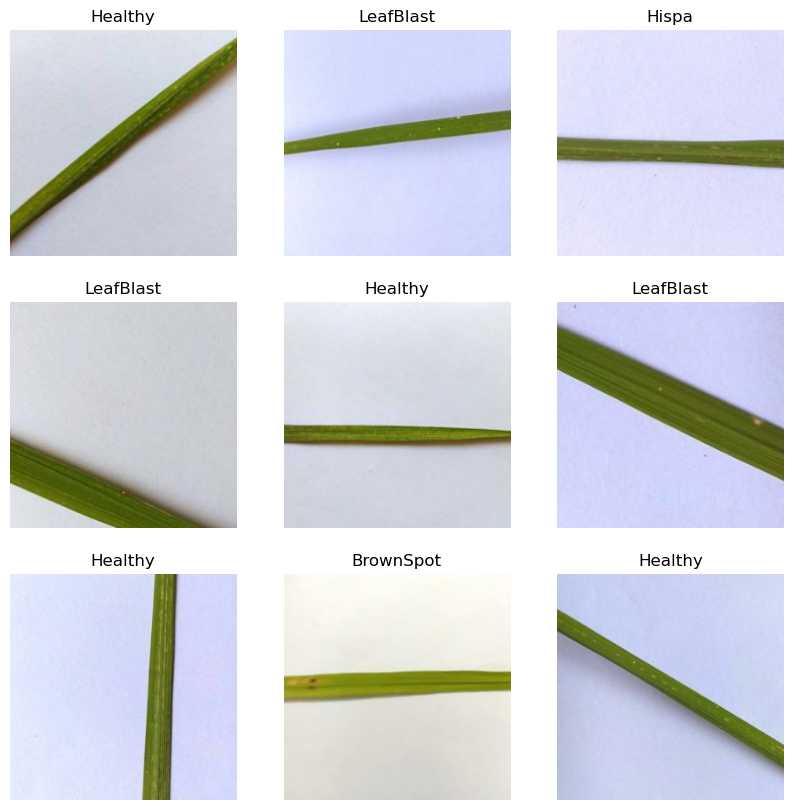

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in data_training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(15, 224, 224, 3)
(15,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

data_train = data_training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
data_test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = data_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9575426


In [12]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.5),
  ]
)

# **Membuat Model**

In [13]:
print(img_size)

(224, 224, 3)


In [14]:
MobileNetV3Large  = tf.keras.applications.MobileNetV3Large(input_shape=img_size, include_top=False, weights='imagenet')

MobileNetV3Large.trainable = False

In [15]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  MobileNetV3Large,
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
  layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.5),
  #MobileNetV3Small,
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  #layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          276512    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)              

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_dtype=True, dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
epochs=30
history_1 = model.fit(
  data_train,
  validation_data=data_test,
  epochs=epochs
)

Epoch 1/30
162/162 [==============================] - 62s 327ms/step - loss: 1.2200 - accuracy: 0.4948 - val_loss: 0.9562 - val_accuracy: 0.6126
Epoch 2/30
162/162 [==============================] - 44s 271ms/step - loss: 1.0533 - accuracy: 0.5754 - val_loss: 0.8854 - val_accuracy: 0.6426
Epoch 3/30
162/162 [==============================] - 44s 269ms/step - loss: 1.0005 - accuracy: 0.5998 - val_loss: 0.8018 - val_accuracy: 0.6877
Epoch 4/30
162/162 [==============================] - 44s 270ms/step - loss: 0.9744 - accuracy: 0.6015 - val_loss: 0.8195 - val_accuracy: 0.6547
Epoch 5/30
162/162 [==============================] - 43s 268ms/step - loss: 0.9434 - accuracy: 0.6151 - val_loss: 0.8093 - val_accuracy: 0.6697
Epoch 6/30
162/162 [==============================] - 44s 269ms/step - loss: 0.9194 - accuracy: 0.6445 - val_loss: 0.7339 - val_accuracy: 0.7087
Epoch 7/30
162/162 [==============================] - 44s 270ms/step - loss: 0.9060 - accuracy: 0.6424 - val_loss: 0.6947 - val_ac

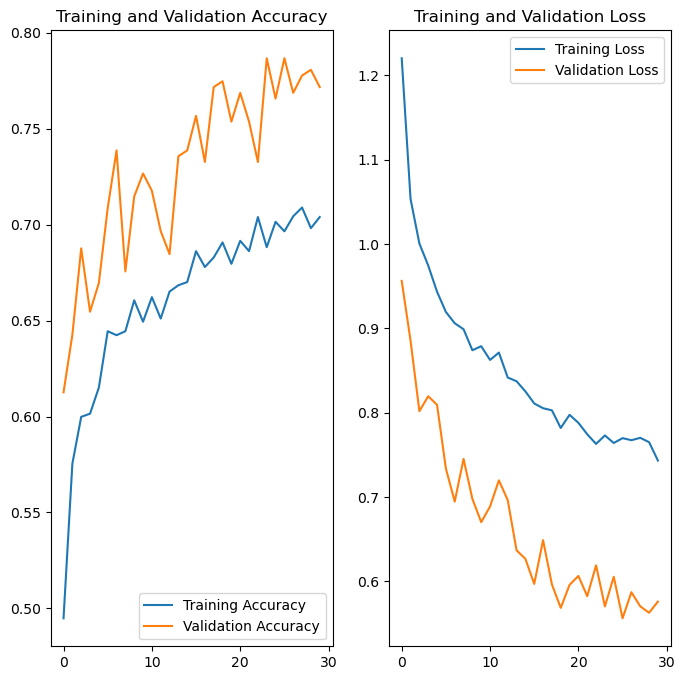

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Testing Model**

In [20]:
loss, accuracy=model.evaluate(data_test)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

23/23 [==============================] - 5s 220ms/step - loss: 0.5761 - accuracy: 0.7718
Accuracy:0.7717717885971069
Loss:0.5761420726776123


In [21]:
x_val=[]
y_val=[]


for image, label in data_test:
    x_val.extend(image.numpy())
    y_val.extend(label.numpy())

In [22]:
preds=model.predict(np.array(x_val))
y_pred = np.argmax(preds, axis=1)


11/11 [==============================] - 7s 441ms/step


F1-Score:[0.7323082216434817]
Precision:[0.7237433174933176]
Recall:[0.8048561966975141]
Classification_Report
-----------------------
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        52
           1       0.77      0.87      0.82       148
           2       0.86      0.34      0.49        56
           3       0.69      0.86      0.76        77

    accuracy                           0.77       333
   macro avg       0.80      0.72      0.73       333
weighted avg       0.79      0.77      0.76       333

Confusion_Matrix
----------------------


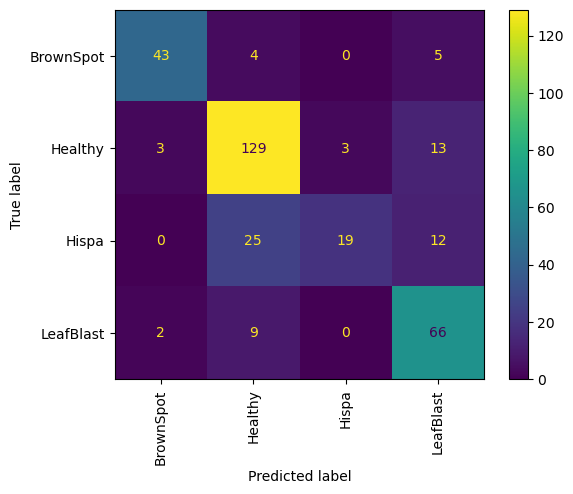

In [23]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report

f1_scores=[]
precision_scores=[]
recall_scores=[]

f1_scores.append(f1_score(y_pred, y_val, average="macro"))
precision_scores.append(precision_score(y_pred, y_val, average="macro"))
recall_scores.append(recall_score(y_pred, y_val, average="macro"))


# Print the Results
print(f"F1-Score:{f1_scores}")
print(f"Precision:{precision_scores}")
print(f"Recall:{recall_scores}")



print("Classification_Report")
print("-----------------------")
print(classification_report(y_val,y_pred))
print("Confusion_Matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=class_names, xticks_rotation="vertical")
plt.show()

# **Percobaan model dengan gambar**

1/1 [==============================] - 0s 106ms/step
This image most likely belongs to Leafblast with a 97.54 percent confidence.


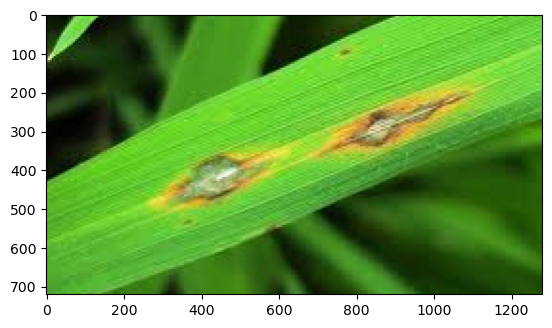

In [33]:
test_dirr = "leafblast1.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 990ms/step
This image most likely belongs to Brownspot with a 99.24 percent confidence.


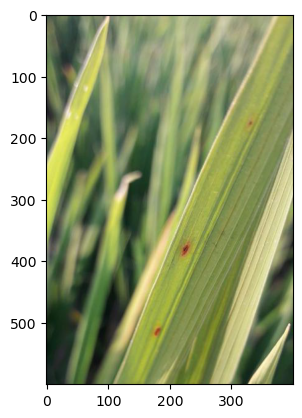

In [34]:
test_dirr = "brownsspot.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 89ms/step
This image most likely belongs to Healthy with a 68.60 percent confidence.


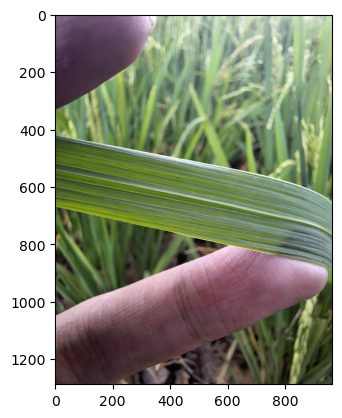

In [39]:
test_dirr = "obs2.jpg"

img = tf.keras.utils.load_img(
    test_dirr, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
im = Image.open(test_dirr)
plt.imshow(im)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, 'padi.hdf5')
print("Model Saved")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_withaug)
tflite_model = converter.convert()

with open("modelpadi.tflite", "wb") as f:
  f.write(tflite_model)